C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:29: RuntimeWarning: overflow encountered in square
  return 0.5 * np.sum(u**2)
C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:50: RuntimeWarning: overflow encountered in scalar power
  term1 = -C / 4 * (u_new[n, m_plus] + u_new[n, m])**2
C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:51: RuntimeWarning: overflow encountered in scalar power
  term2 = C / 4 * (u_new[n, m] + u_new[n, m_minus])**2
C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:52: RuntimeWarning: invalid value encountered in scalar add
  u_new[n+1, m] = u_new[n-1, m] + term1 + term2
C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:110: RuntimeWarning: overflow encountered in scalar multiply
  u_new[n+1, m] = u_new[n-1, m] - C * u_new[n, m] * (u_new[n, m_plus] - u_new[n, m_minus])
C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:110: RuntimeWarning: invalid value encountered in scalar multiply
  u_new[n+1, m] =

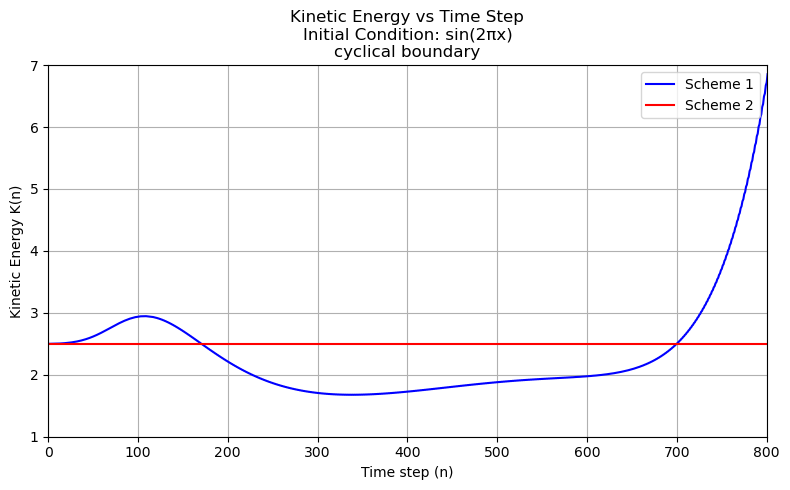

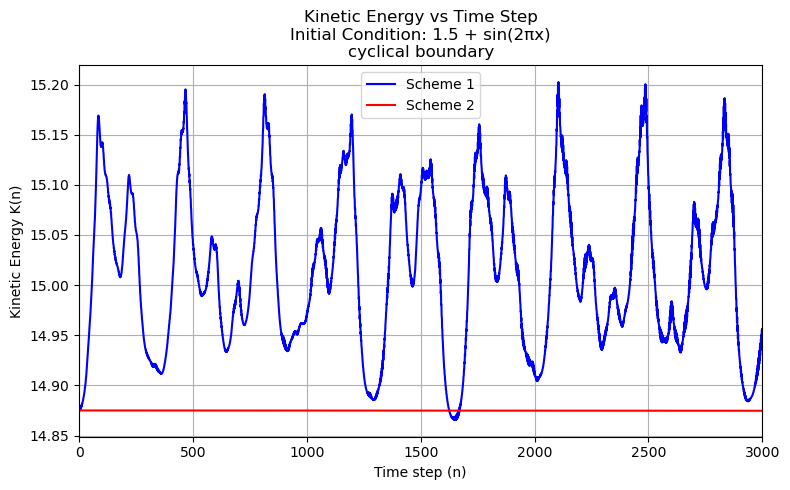

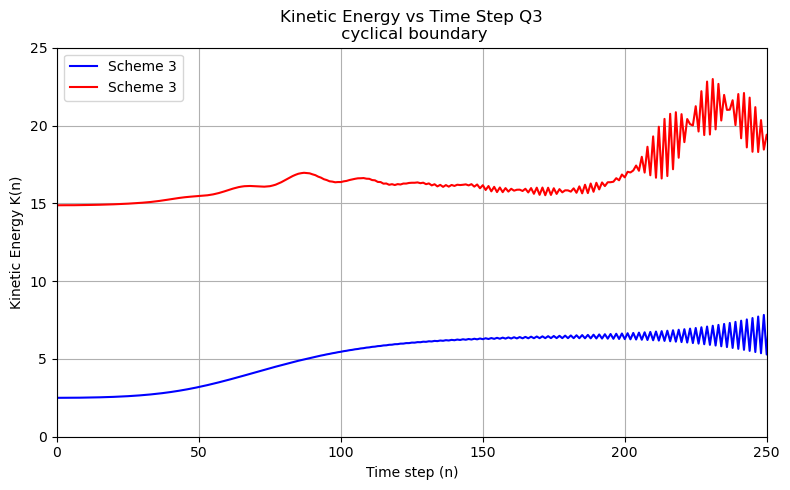

In [45]:
import numpy as np
import matplotlib.pyplot as plt


dx = 0.1
dt = 0.004
L = 1.0
nx = int(L / dx) + 1  # Number of spatial points 
nt = 3000  # Number of time steps
T = nt * dt
x = np.linspace(0, L, nx)
C = dt / dx

# Initial conditions
def initial_condition1(x):
    return np.sin(2 * np.pi * x)

def initial_condition2(x):
    return 0.5 + np.sin(2 * np.pi * x)

def initial_condition3(x):
    return 1.0 + np.sin(2 * np.pi * x)

def initial_condition4(x):
    return 1.5 + np.sin(2 * np.pi * x)

# K(n) 
def kinetic_energy(u):
    return 0.5 * np.sum(u**2)  

# 差分格式1，周期性边界条件
def scheme1_cycle(u, nt, nx, C):
    u_new = np.zeros((nt, nx))
    u_new[0, :] = u[0, :]
    K = np.zeros(nt)
    K[0] = kinetic_energy(u_new[0, :]) 
    
    for m in range(nx):
        m_plus = (m + 1) % nx
        m_minus = (m - 1) % nx
        term1 = (u_new[0, m_plus] + u_new[0, m])**2
        term2 = (u_new[0, m] + u_new[0, m_minus])**2
        u_new[1, m] = u_new[0, m] - C / 8 * (term1 - term2)
    K[1] = kinetic_energy(u_new[1, :])  
    
    for n in range(1, nt-1):
        for m in range(nx):
            m_plus = (m + 1) % nx
            m_minus = (m - 1) % nx
            term1 = -C / 4 * (u_new[n, m_plus] + u_new[n, m])**2
            term2 = C / 4 * (u_new[n, m] + u_new[n, m_minus])**2
            u_new[n+1, m] = u_new[n-1, m] + term1 + term2
        K[n+1] = kinetic_energy(u_new[n+1, :])  
    
    return u_new, K

# 差分格式2，周期性边界条件
def scheme2_cycle(u, nt, nx, C, tol=1e-5, max_iter=1000):
    u_new = np.zeros((nt, nx))
    u_new[0, :] = u[0, :]
    K = np.zeros(nt)
    K[0] = kinetic_energy(u_new[0, :]) 
    
    for n in range(0, nt-1):
        u_star = u_new[n, :].copy()
        u_prev = u_new[n, :].copy()
        
        for _ in range(max_iter):
            u_bar = u_prev
            u_next = np.zeros(nx)
            
            for m in range(nx):
                m_plus = (m + 1) % nx
                m_minus = (m - 1) % nx
                avg_u = (u_bar[m_plus] + u_bar[m] + u_bar[m_minus]) / 3
                flux = avg_u * (u_bar[m_plus] - u_bar[m_minus])
                u_next[m] = u_new[n, m] - C / 6 * flux
            
            # Update u_bar for next iteration
            u_bar = 0.5 * (u_next + u_new[n, :])
            error = np.max(np.abs(u_next - u_star))
            u_star = u_next.copy()
            
            if error < tol:
                u_new[n+1, :] = u_next
                break
            u_prev = u_bar
        
        K[n+1] = kinetic_energy(u_new[n+1, :])  
    
    return u_new, K

# 差分格式3，周期性边界条件
def scheme3_cycle(u, nt, nx, C):
    u_new = np.zeros((nt, nx))
    u_new[0, :] = u[0, :]
    K = np.zeros(nt)
    K[0] = kinetic_energy(u_new[0, :])  

    for m in range(nx):
        m_plus = (m + 1) % nx
        m_minus = (m - 1) % nx
        u_new[1, m] = u_new[0, m] - 0.5 * C * u_new[0, m] * (u_new[0, m_plus] - u_new[0, m_minus])
    K[1] = kinetic_energy(u_new[1, :])

    for n in range(1, nt - 1):
        for m in range(nx):
            m_plus = (m + 1) % nx
            m_minus = (m - 1) % nx
            u_new[n+1, m] = u_new[n-1, m] - C * u_new[n, m] * (u_new[n, m_plus] - u_new[n, m_minus])
        K[n+1] = kinetic_energy(u_new[n+1, :])

    return u_new, K


# 初始化 u 数组
u1 = np.zeros((nt, nx))
u4 = np.zeros((nt, nx))
u1[0, :] = initial_condition1(x)
u4[0, :] = initial_condition4(x)

# 运行两种差分格式
_, K1_init1 = scheme1_cycle(u1, nt, nx, C)
_, K2_init1 = scheme2_cycle(u1, nt, nx, C)
_, K3_init1 = scheme3_cycle(u1, nt, nx, C)

_, K1_init4 = scheme1_cycle(u4, nt, nx, C)
_, K2_init4 = scheme2_cycle(u4, nt, nx, C)
_, K3_init4 = scheme3_cycle(u4, nt, nx, C)


# 绘制第一张图：（sin(2πx)）
plt.figure(figsize=(8, 5))
plt.plot(K1_init1, label='Scheme 1', color='blue')
plt.plot(K2_init1, label='Scheme 2', color='red')
plt.xlim(0, 800)
plt.ylim(1, 7)
plt.title('Kinetic Energy vs Time Step\nInitial Condition: sin(2πx)\ncyclical boundary')
plt.xlabel('Time step (n)')
plt.ylabel('Kinetic Energy K(n)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 绘制第二张图：（1.5 + sin(2πx)）
plt.figure(figsize=(8, 5))
plt.plot(K1_init4, label='Scheme 1', color='blue')
plt.plot(K2_init4, label='Scheme 2', color='red')
plt.title('Kinetic Energy vs Time Step\nInitial Condition: 1.5 + sin(2πx)\ncyclical boundary')
plt.xlabel('Time step (n)')
plt.ylabel('Kinetic Energy K(n)')
plt.xlim(0, 3000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 绘制差分格式3动能变化图
plt.figure(figsize=(8, 5))
plt.plot(K3_init1, label='Scheme 3', color='blue')
plt.plot(K3_init4, label='Scheme 3', color='red')
plt.xlim(0, 250)
plt.ylim(0, 25)
plt.title('Kinetic Energy vs Time Step Q3\n cyclical boundary')
plt.xlabel('Time step (n)')
plt.ylabel('Kinetic Energy K(n)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_11272\816161031.py:29: RuntimeWarning: overflow encountered in square
  return 0.5 * np.sum(u**2)
C:\Users\A\AppData\Local\Temp\ipykernel_11272\1579973309.py:96: RuntimeWarning: overflow encountered in scalar multiply
  u_new[n+1, m] = u_new[n-1, m] - C * u_new[n, m] * (u_new[n, m + 1] - u_new[n, m - 1])
C:\Users\A\AppData\Local\Temp\ipykernel_11272\1579973309.py:96: RuntimeWarning: invalid value encountered in scalar subtract
  u_new[n+1, m] = u_new[n-1, m] - C * u_new[n, m] * (u_new[n, m + 1] - u_new[n, m - 1])
C:\Users\A\AppData\Local\Temp\ipykernel_11272\1579973309.py:20: RuntimeWarning: overflow encountered in scalar power
  term1 = -C / 4 * (u_new[n, m + 1] + u_new[n, m])**2
C:\Users\A\AppData\Local\Temp\ipykernel_11272\1579973309.py:21: RuntimeWarning: overflow encountered in scalar power
  term2 = C / 4 * (u_new[n, m] + u_new[n, m - 1])**2
C:\Users\A\AppData\Local\Temp\ipykernel_11272\1579973309.py:22: RuntimeWarning: invalid value encoun

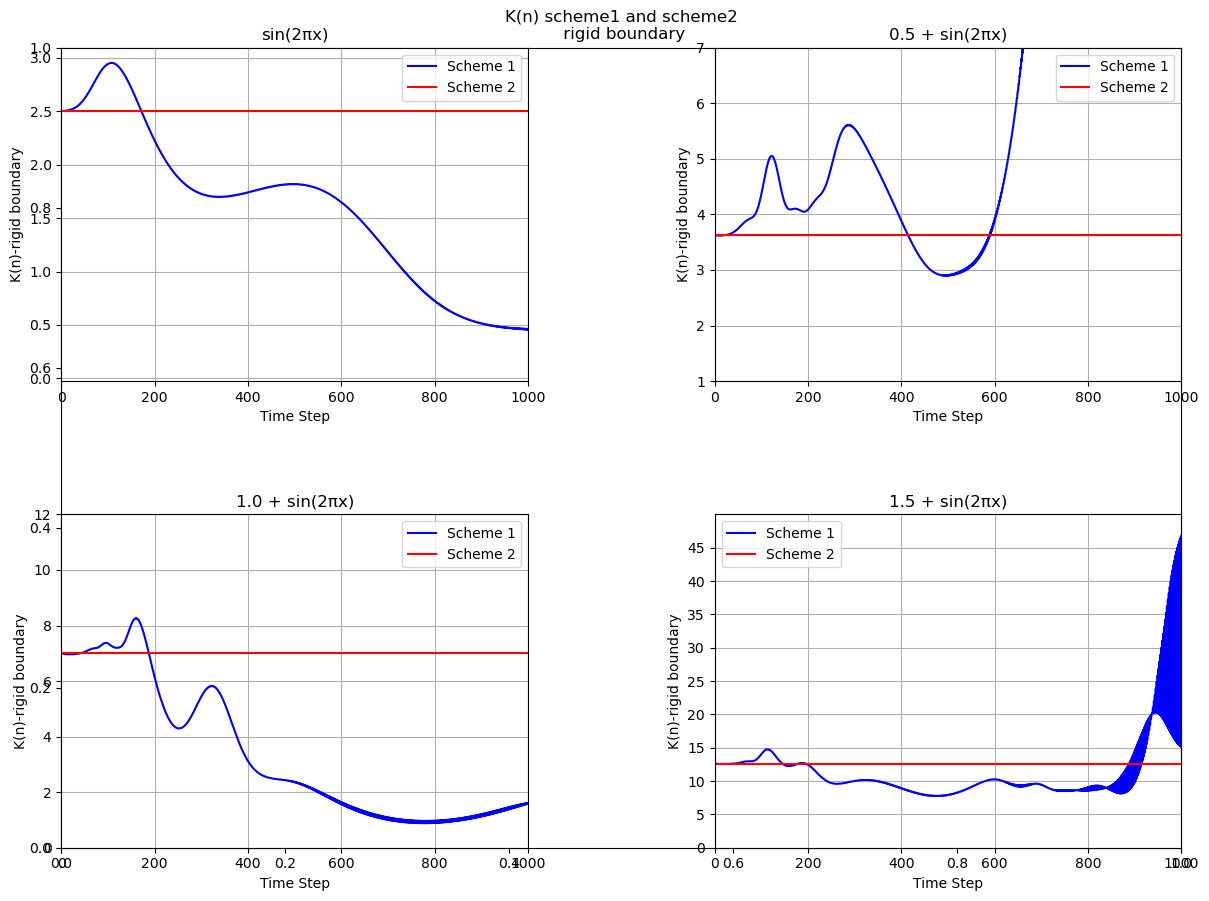

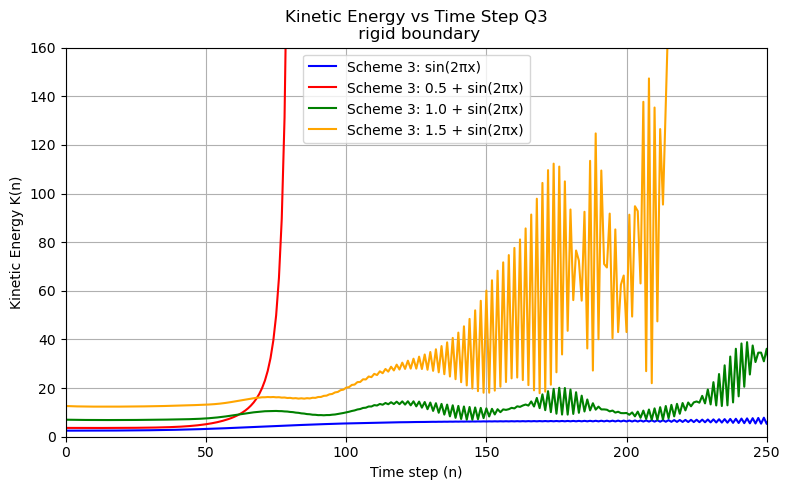

In [57]:
# 差分格式1，刚性边界条件
def scheme1_rigid(u, nt, nx, C):
    u_new = np.zeros((nt, nx))
    u_new[0, :] = u[0, :]
    u_new[0, 0]  = 0
    u_new[0, -1] = 0
    K = np.zeros(nt)
    K[0] = kinetic_energy(u_new[0, :])    
    
    for m in range(1, nx-1):  
        term1 = (u_new[0,  m + 1] + u_new[0, m])**2
        term2 = (u_new[0, m] + u_new[0, m - 1])**2
        u_new[1, m] = u_new[0, m] - C / 8 * (term1 - term2)
    u_new[1, 0] = 0
    u_new[1, -1] = 0
    K[1] = kinetic_energy(u_new[1, :])  

    for n in range(1, nt-1):
        for m in range(1, nx-1):  
            term1 = -C / 4 * (u_new[n, m + 1] + u_new[n, m])**2
            term2 = C / 4 * (u_new[n, m] + u_new[n, m - 1])**2
            u_new[n+1, m] = u_new[n-1, m] + term1 + term2
        u_new[n+1, 0] = 0
        u_new[n+1, -1] = 0
        K[n+1] = kinetic_energy(u_new[n+1, :]) 
   
    return u_new, K


# 差分格式2，刚性边界条件
def scheme2_rigid(u, nt, nx, C, tol=1e-5, max_iter=1000):
    u_new = np.zeros((nt, nx))
    u_new[0, :] = u[0, :]
    u_new[0, 0] = 0
    u_new[0, -1] = 0
    
    K = np.zeros(nt)
    K[0] = kinetic_energy(u_new[0, :])  
    
    for n in range(0, nt-1):
        u_star = u_new[n, :].copy()
        u_prev = u_new[n, :].copy()
        u_prev[0] = 0
        u_prev[-1] = 0
        
        for _ in range(max_iter):
            u_bar = u_prev
            u_next = np.zeros(nx)
            
            for m in range(1, nx-1):
                avg_u = (u_bar[m + 1] + u_bar[m] + u_bar[m - 1]) / 3
                flux = avg_u * (u_bar[m + 1] - u_bar[m - 1])
                u_next[m] = u_new[n, m] - C / 6 * flux
            u_next[0] = 0
            u_next[-1] = 0
            
            # Update u_bar for next iteration
            u_bar = 0.5 * (u_next + u_new[n, :])
            u_bar[0] = 0
            u_bar[-1] = 0
            
            error = np.max(np.abs(u_next - u_star))
            u_star = u_next.copy()
            
            if error < tol:
                u_new[n+1, :] = u_next
                break
            u_prev = u_bar

        u_new[n+1, 0] = 0
        u_new[n+1, -1] = 0
        
        K[n+1] = kinetic_energy(u_new[n+1, :]) 
    
    return u_new, K


# 差分格式3，刚性边界条件
def scheme3_rigid(u, nt, nx, C):
    u_new = np.zeros((nt, nx))
    u_new[0, :] = u[0, :]
    u_new[0, 0] = 0
    u_new[0, -1] = 0
    
    K = np.zeros(nt)
    K[0] = kinetic_energy(u_new[0, :]) 

    for m in range(1, nx-1):
        u_new[1, m] = u_new[0, m] - 0.5 * C * u_new[0, m] * (u_new[0,  m + 1] - u_new[0, m - 1])
    u_new[1, 0] = 0
    u_new[1, -1] = 0
    K[1] = kinetic_energy(u_new[1, :])

    for n in range(1, nt - 1):
        for m in range(1, nx-1):
            u_new[n+1, m] = u_new[n-1, m] - C * u_new[n, m] * (u_new[n, m + 1] - u_new[n, m - 1])
        u_new[n+1, 0] = 0
        u_new[n+1, -1] = 0
        K[n+1] = kinetic_energy(u_new[n+1, :])

    return u_new, K


# 初始化初始条件
u1 = np.zeros((nt, nx))
u2 = np.zeros((nt, nx))
u3 = np.zeros((nt, nx))
u4 = np.zeros((nt, nx))
u1[0, :] = initial_condition1(x)
u2[0, :] = initial_condition2(x)
u3[0, :] = initial_condition3(x)
u4[0, :] = initial_condition4(x)

# Run schemes with rigid boundaries
_, K1_init1 = scheme1_rigid(u1, nt, nx, C)
_, K2_init1 = scheme2_rigid(u1, nt, nx, C)
_, K3_init1 = scheme3_rigid(u1, nt, nx, C)

_, K1_init2 = scheme1_rigid(u2, nt, nx, C)
_, K2_init2 = scheme2_rigid(u2, nt, nx, C)
_, K3_init2 = scheme3_rigid(u2, nt, nx, C)

_, K1_init3 = scheme1_rigid(u3, nt, nx, C)
_, K2_init3 = scheme2_rigid(u3, nt, nx, C)
_, K3_init3 = scheme3_rigid(u3, nt, nx, C)

_, K1_init4 = scheme1_rigid(u4, nt, nx, C)
_, K2_init4 = scheme2_rigid(u4, nt, nx, C)
_, K3_init4 = scheme3_rigid(u4, nt, nx, C)

#差分格式1、2
plt.figure(figsize=(14, 10))
plt.title('K(n) scheme1 and scheme2\n rigid boundary')

plt.subplot(2, 2, 1)
plt.plot(K1_init1, label='Scheme 1', color='blue')
plt.plot(K2_init1, label='Scheme 2', color='red')
plt.xlim(0, 1000)
plt.yticks(np.arange(0, 3.1, 0.5)) 
plt.xlabel('Time Step')
plt.ylabel('K(n)-rigid boundary')
plt.title('sin(2πx)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(K1_init2, label='Scheme 1', color='blue')
plt.plot(K2_init2, label='Scheme 2', color='red')
plt.xlim(0, 1000)
plt.ylim(1,7)
plt.xlabel('Time Step')
plt.ylabel('K(n)-rigid boundary')
plt.title('0.5 + sin(2πx)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(K1_init3, label='Scheme 1', color='blue')
plt.plot(K2_init3, label='Scheme 2', color='red')
plt.ylim(0, 12)
plt.xlim(0, 1000)
plt.xlabel('Time Step')
plt.ylabel('K(n)-rigid boundary')
plt.title('1.0 + sin(2πx)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(K1_init4, label='Scheme 1', color='blue')
plt.plot(K2_init4, label='Scheme 2', color='red')
plt.xlim(0, 1000)
plt.ylim(0,50)
plt.yticks(np.arange(0, 50, 5)) 
plt.xlabel('Time Step')
plt.ylabel('K(n)-rigid boundary')
plt.title('1.5 + sin(2πx)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 差分格式3
plt.figure(figsize=(8, 5))
plt.plot(K3_init1, label='Scheme 3: sin(2πx)', color='blue')
plt.plot(K3_init2, label='Scheme 3: 0.5 + sin(2πx)', color='red')
plt.plot(K3_init3, label='Scheme 3: 1.0 + sin(2πx)', color='green')
plt.plot(K3_init4, label='Scheme 3: 1.5 + sin(2πx)', color='orange')
plt.xlim(0, 250)
plt.ylim(0, 160)
plt.title('Kinetic Energy vs Time Step Q3\n rigid boundary')
plt.xlabel('Time step (n)')
plt.ylabel('Kinetic Energy K(n)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()